In [1]:
import os
import re
import math
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get the user's home directory (e.g., 'C:\Users\user')
DATA_DIR = r"C:\Users\ferit\MLPC2025_dataset"

### Metadata

In [3]:
# Load metadata
metadata = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))

print(f"Metadata: {metadata.shape}")
print(metadata.columns.tolist())

Metadata: (9026, 12)
['filename', 'keywords', 'freesound_id', 'sound_link', 'manufacturer', 'license', 'title', 'description', 'num_downloads', 'geotag', 'start_time_s', 'end_time_s']


### Metadata Embeddings

In [4]:
# Load metadata embeddings
title_embeddings = np.load(os.path.join(DATA_DIR, "metadata_title_embeddings.npz"))["embeddings"]
keywords_embeddings = np.load(os.path.join(DATA_DIR, "metadata_keywords_embeddings.npz"))["embeddings"]

print(f"Metadata Title Embeddings:    {title_embeddings.shape}")
print(f"Metadata Keywords Embeddings: {keywords_embeddings.shape}")

Metadata Title Embeddings:    (9026, 1024)
Metadata Keywords Embeddings: (9026, 1024)


### Annotations

In [5]:
# Load annotations 
annotations = pd.read_csv(os.path.join(DATA_DIR, "annotations.csv"))

print(f"Annotations: {annotations.shape}")
print(annotations.columns.tolist())

Annotations: (35826, 7)
['task_id', 'filename', 'annotator', 'text', 'onset', 'offset', 'filename_unsafe']


### Annotations Embeddings

In [6]:
# Load annotations embeddings
annotations_embeddings = np.load(os.path.join(DATA_DIR, "annotations_text_embeddings.npz"))["embeddings"]
print(f"Annotations Embeddings:    {annotations_embeddings.shape}")

Annotations Embeddings:    (35826, 1024)


### Audio Features

In [7]:
# Load audio features
audio_features_dir = f"{DATA_DIR}/audio_features"
audio_feature_filename = metadata.loc[0, "filename"].replace("mp3", "npz")
audio_features = np.load(os.path.join(audio_features_dir, audio_feature_filename))

# Print individual audio feature shapes
max_key_len = len(max(audio_features.keys()))
for key in audio_features.keys():
    print(f"Audio feature[{key}]:{' ' * (max_key_len - len(key))} (time, n_features) {audio_features[key].shape}")

# Concatenate all audio features along axis=1 (feature dimension)
all_audio_features = np.hstack([audio_features[k] for k in audio_features.keys()])

# Verify the combined audio feature shape
print(f"\nAudio feature(combined):{' ' * (max_key_len - len('combined'))} (time, n_features) {all_audio_features.shape}")

Audio feature[embeddings]:       (time, n_features) (233, 768)
Audio feature[melspectrogram]:   (time, n_features) (233, 64)
Audio feature[mfcc]:             (time, n_features) (233, 32)
Audio feature[mfcc_delta]:       (time, n_features) (233, 32)
Audio feature[mfcc_delta2]:      (time, n_features) (233, 32)
Audio feature[flatness]:         (time, n_features) (233, 1)
Audio feature[centroid]:         (time, n_features) (233, 1)
Audio feature[flux]:             (time, n_features) (233, 1)
Audio feature[energy]:           (time, n_features) (233, 1)
Audio feature[power]:            (time, n_features) (233, 1)
Audio feature[bandwidth]:        (time, n_features) (233, 1)
Audio feature[contrast]:         (time, n_features) (233, 7)
Audio feature[zerocrossingrate]: (time, n_features) (233, 1)

Audio feature(combined):         (time, n_features) (233, 942)


## Task 1: Case Study:

### Task 1 (a): Identify similarities or differences between temporal and textual annotations from different annotators.

##### Illustration of temporal aggrement for different annotations:
*Case 1: Perfect Overlap (IoU = 1.0)*
```text
Annotation A:  |==========|  (2s-12s)
Annotation B:  |==========|  (2s-12s)
Intersection:  |==========|  (10s)
Union:         |==========|  (10s)
IoU = 10 / 10 = 1.0
```
*Case 2: Partial Overlap (0.0 < IoU < 1.0)*
```text
Annotation A:  |========|    (2s-10s)
Annotation B:      |======|  (6s-12s)
Intersection:      |====|    (4s)
Union:         |==========|  (10s)
IoU = 4 / 10 = 0.4
```
*Case 3: No Overlap (IoU = 0.0)*
```text
Annotation A:  |====|        (2s-6s)
Annotation B:        |====|  (8s-12s)
Intersection:       ||       (0s)
Union:         |==========|  (10s)
IoU = 0 / 10 = 0.0
```

##### Illustration of textual similarity for different annotations:
<img src="https://memgraph.com/images/blog/cosine-similarity-python-scikit-learn/cosine-similarity.png" alt="cosine-similarity" width="1000"/>

The cosine similarity between two vectors $(A)$ and $(B)$ is calculated as:

$$
\textit{similarity}(A,B) = \cos(\theta) = \frac{A \cdot B}{\|A\|\ \|B\|} = \frac{\sum\limits_{i=1}^n A_i B_i}{\sqrt{\sum\limits_{i=1}^n A_i^2} \sqrt{\sum\limits_{i=1}^n B_i^2}}
$$

*Source: [memgraph.com](https://memgraph.com/blog/cosine-similarity-python-scikit-learn)*

#### Illustration generating unique comparison pairs (excluding self-comparison)

In [8]:
# Annotations Agreement Calculation
def annotations_agreement(group):
    
    if len(group) < 2:
        return None

    # Temporal analysis
    times = group[['onset', 'offset']].values
    
    # Generate unique comparison pairs (excluding self-comparison)
    pairs = np.array(np.triu_indices(len(times), k=1)).T
    
    if len(pairs) > 0:
        
        # Calculate intersections
        min_ends = np.minimum(times[pairs[:, 0], 1], times[pairs[:, 1], 1])
        max_starts = np.maximum(times[pairs[:, 0], 0], times[pairs[:, 1], 0])
        intersections = np.maximum(0, min_ends - max_starts)
        
        # Calculate unions       
        max_ends = np.maximum(times[pairs[:, 0], 1], times[pairs[:, 1], 1])
        min_starts = np.minimum(times[pairs[:, 0], 0], times[pairs[:, 1], 0])
        unions = max_ends - min_starts

        # Calculate Temporal IoU (intersection over union)
        temporal_ious = np.where(unions > 0, intersections / unions, 0)
        mean_iou = np.mean(temporal_ious)
        mean_overlap = np.mean(intersections)
    else:
        mean_iou = 0
        mean_overlap = 0

    # Textual analysis
    # Calculate cosine similarity matrix between all annotation embeddings
    similarity_matrix = cosine_similarity(annotations_embeddings[group.index])
    
    # Extract unique pairwise similarities (excluding self-similarities)
    text_sims = similarity_matrix[np.triu_indices(len(group), k=1)]
    
    return pd.Series({
        'temporal_iou': mean_iou,
        'temporal_overlap': mean_overlap,
        'textual_sim': np.mean(text_sims),
        'textual_sim_std': np.std(text_sims),
        'n_annotations': len(group),
        'n_annotators': group['annotator'].nunique()
    })

# Calculate stats
stats = annotations.groupby('filename').apply(annotations_agreement).dropna()
stats['combined_agreement'] = (stats['temporal_iou'] + stats['textual_sim'])/2

In [9]:
# Finding Extreme Agreement/Disagreement on Annotations
valid_files = stats[stats['n_annotators'] >= 2] # Require at least 2 annotators

if len(valid_files) > 0:
    # Find the file with HIGHEST agreement
    similar = valid_files.nlargest(1, 'combined_agreement').index[0]

    # Find the file with LOWEST agreement 
    different = valid_files.nsmallest(1, 'combined_agreement').index[0]
else:
    raise ValueError("No qualifying files found")

In [10]:
def plot_metadata_alignment(filename):

    # Display detailed analysis for a case study file
    file_annots = annotations[annotations['filename'] == filename]
    meta_idx = metadata[metadata['filename'] == filename].index[0]
    
    # Calculate similarities
    title_sims = cosine_similarity(title_embeddings[meta_idx].reshape(1, -1), annotations_embeddings[file_annots.index])[0]
    keywords_sims = cosine_similarity(keywords_embeddings[meta_idx].reshape(1, -1), annotations_embeddings[file_annots.index])[0]
    
    # Create plot
    plt.figure(figsize=(25, 4))
    plt.imshow(np.vstack([title_sims, keywords_sims]), cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
    
    plt.colorbar(label="Similarity Score")
    plt.title(f"Metadata Alignment\n{filename}", pad=15)
    plt.yticks([0, 1], ["Title Similarity", "Keywords Similarity"])
    plt.xticks(range(len(file_annots)), [f"A{i+1}" for i in range(len(file_annots))])
    
    for i in range(2):
        for j in range(len(file_annots)):
            plt.text(j, i, f"{[title_sims, keywords_sims][i][j]:.2f}", ha='center', va='center', color='black')
    
    plt.tight_layout()
    plt.show()

In [11]:
# Printing Case Study Results
def print_case_study(filename):
    
    # Display detailed analysis for a case study file
    file_annots = annotations[annotations['filename'] == filename]
    file_stats = stats.loc[filename]
    
    print(f"{'='*80}")
    print(f"{'Case Study File: ':<20}{filename}")
    print(f"{'Duration: ':<20}{file_annots['offset'].max():.1f}s")
    print(f"\nAgreement Scores:")
    print(f"{'- Temp. IoU: ':<20}{file_stats['temporal_iou']:.2f} (Mean overlap: {file_stats['temporal_overlap']:.1f}s)")
    print(f"{'- Text. Sim: ':<20}{file_stats['textual_sim']:.2f} ± {file_stats['textual_sim_std']:.2f}")
    
    print("\nAnnotations Timeline:")
    for _, row in file_annots.sort_values(['annotator', 'onset']).iterrows():
        print(f"[{row['onset']:5.1f}s-{row['offset']:5.1f}s] {row['annotator'][:10]}...: \"{row['text']}\"")
    
    # Show metadata alignment
    meta_idx = metadata[metadata['filename'] == filename].index[0]
    print(f"\nMetadata:")
    print(f"{'Title: ':<10}{metadata.loc[meta_idx, 'title']}")
    print(f"{'Keywords: ':<10}{metadata.loc[meta_idx, 'keywords']}")
    
    print(f"\nUnique Annotators: {int(file_stats['n_annotators']):3}")
    print(f"Total Annotations: {int(file_stats['n_annotations']):3}")

    print(f"{'-'*80}")


HIGHEST AGREEMENT CASE:
Case Study File:    449439.mp3
Duration:           18.4s

Agreement Scores:
- Temp. IoU:        1.00 (Mean overlap: 18.3s)
- Text. Sim:        0.93 ± 0.05

Annotations Timeline:
[  0.0s- 18.4s] 1002449017...: "upset and sad female woman continuously crying, sobbing, whimpering "
[  0.1s- 18.4s] 1002449017...: "upset and sad female woman continuously crying, sobbing, whimpering "
[  0.1s- 18.4s] 8018067142...: "A woman crying, sobbing, loudly, really close "

Metadata:
Title:    Woman Crying.wav
Keywords: weep, sobbing, whimper, upset, sad, female-crying, crying, woman-crying

Unique Annotators:   2
Total Annotations:   3
--------------------------------------------------------------------------------


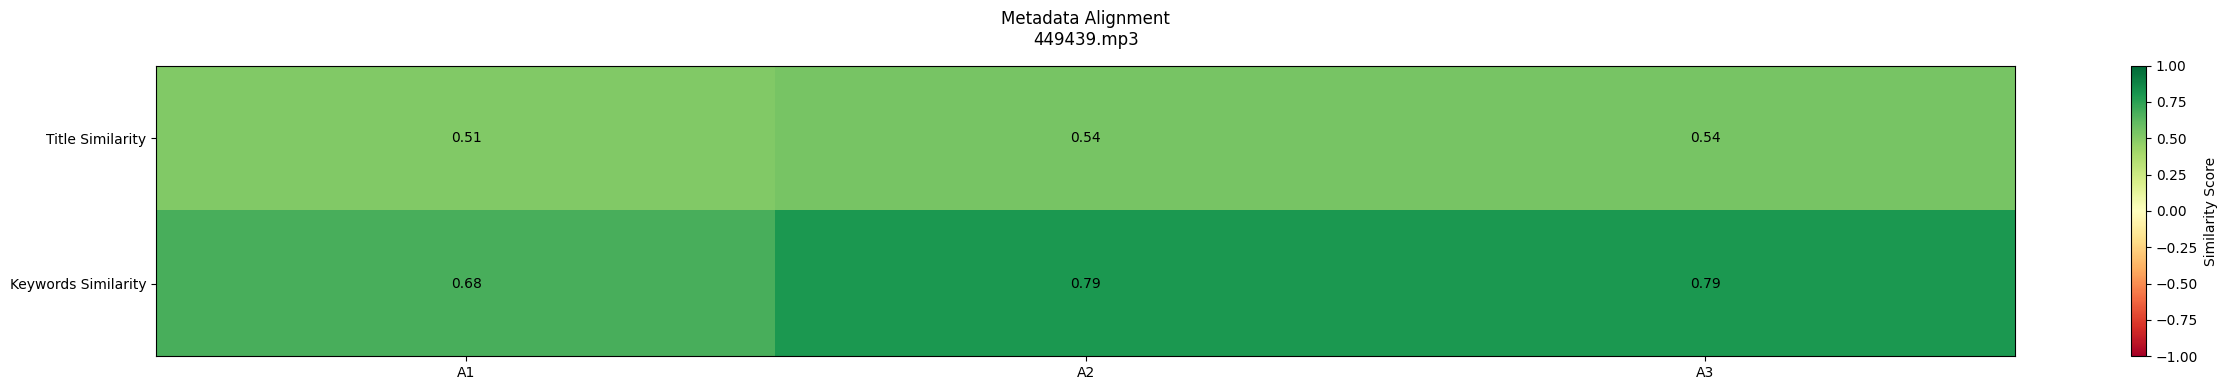


LOWEST AGREEMENT CASE:
Case Study File:    511766.mp3
Duration:           18.8s

Agreement Scores:
- Temp. IoU:        0.04 (Mean overlap: 0.3s)
- Text. Sim:        0.12 ± 0.27

Annotations Timeline:
[  2.0s-  4.0s] 1145579747...: "Clearly speaking person"
[  4.8s-  7.5s] 1145579747...: "Successful attempt to start an engine inside the vehicle"
[  7.5s- 17.4s] 1145579747...: "Varying acceleration auto engine noises"
[ 17.5s- 18.8s] 1145579747...: "Persons speaking quietly in the background"
[  0.0s-  1.8s] 4566938478...: "Distant birds singing"
[  0.0s-  0.4s] 4566938478...: "Human steps"
[  0.5s-  0.9s] 4566938478...: "Human steps"
[  1.2s-  1.8s] 4566938478...: "Noise from touching the reconding device"
[  2.0s-  3.8s] 4566938478...: "Male human speech"
[  3.8s-  4.6s] 4566938478...: "Human steps"
[  4.0s-  4.3s] 4566938478...: "Male human speech"
[  4.8s- 17.5s] 4566938478...: "Engine"
[  4.8s-  7.5s] 4566938478...: "Engine start"
[  7.4s-  9.9s] 4566938478...: "Idling engine"
[  9

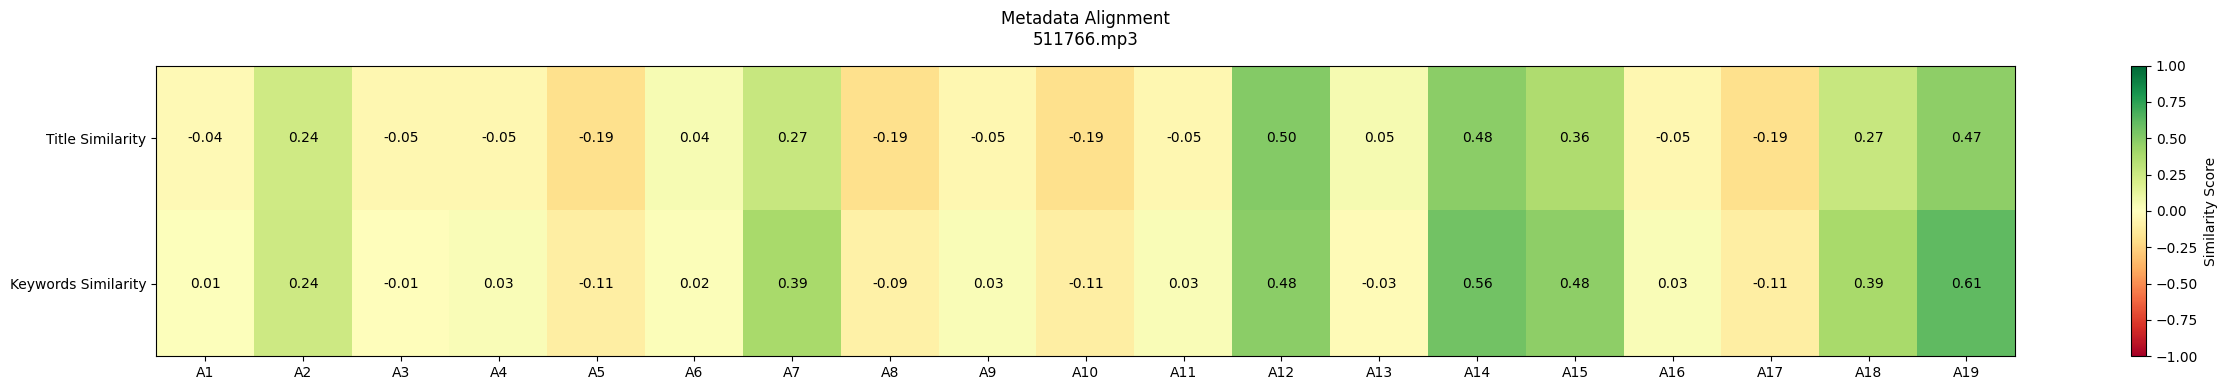

In [12]:
# For highest agreement case
print("\nHIGHEST AGREEMENT CASE:")
print_case_study(similar)
plot_metadata_alignment(similar)

# For lowest agreement case 
print("\nLOWEST AGREEMENT CASE:")
print_case_study(different)
plot_metadata_alignment(different)

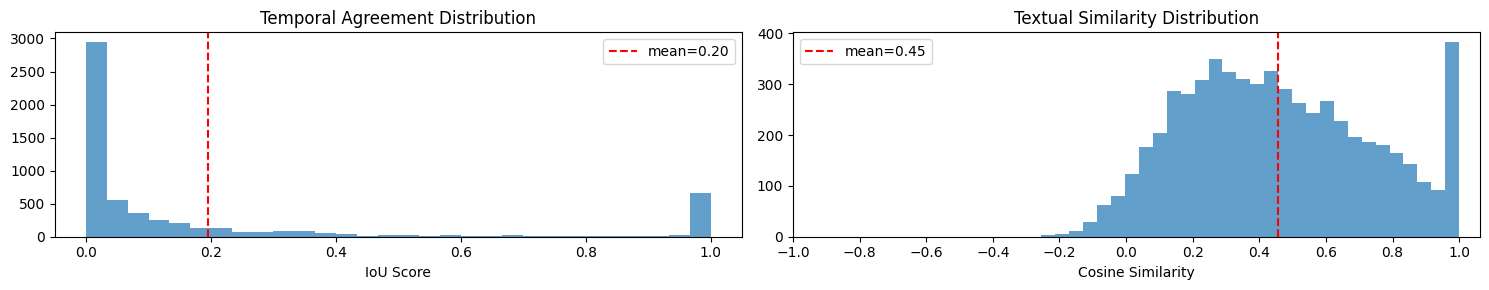

In [13]:
# Enhanced Visualization
plt.figure(figsize=(15, 3))

plt.subplot(1, 2, 1)
plt.hist(stats['temporal_iou'], bins=30, alpha=0.7)
temporal_iou = np.mean(stats['temporal_iou'])
plt.axvline(x=temporal_iou, color='red', linestyle='--', label=f'mean={temporal_iou:4.2f}')
plt.title('Temporal Agreement Distribution')
plt.xlabel('IoU Score')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(stats['textual_sim'], bins=30, alpha=0.7)
textual_sim = np.mean(stats['textual_sim'])
plt.axvline(x=textual_sim, color='red', linestyle='--', label=f'mean={textual_sim:4.2f}')
plt.title('Textual Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.xticks(np.arange(-1.0, 1.1, 0.2))
plt.legend()

plt.tight_layout()
plt.show()

### Task 1 (b): To what extent do the annotations rely on or deviate from keywords and textual descriptions in the audio’s metadata?

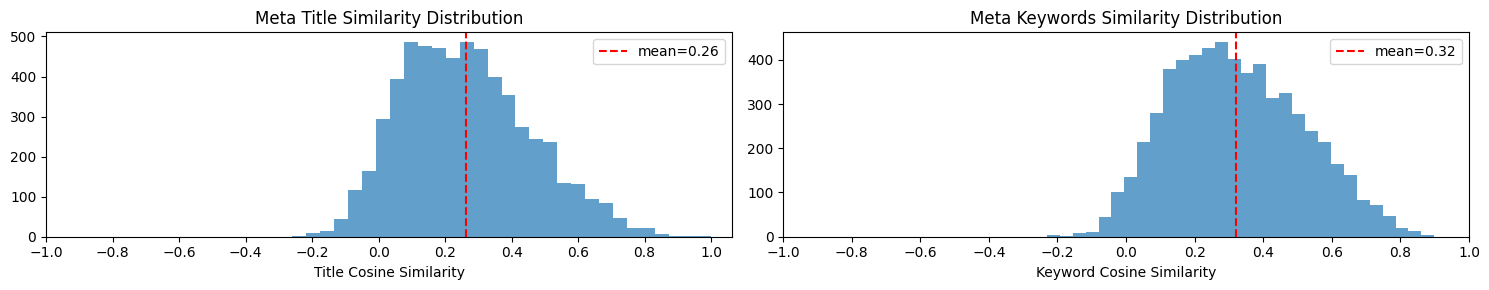

In [14]:
def metadata_alignment_analysis():
    
    # Get metadata indices for all annotated files
    meta_indices = metadata.reset_index().merge(annotations[['filename']].drop_duplicates(), on='filename').set_index('filename')['index']
    
    # Calculate similarities
    results = []
    for filename, group in annotations.groupby('filename'):
        if len(group) < 2:
            continue
        
        meta_idx = meta_indices[filename]
        meta_title_emb = title_embeddings[meta_idx].reshape(1, -1)
        meta_keywords_emb = keywords_embeddings[meta_idx].reshape(1, -1)
        annots_embs = annotations_embeddings[group.index]
        
        title_sims = cosine_similarity(meta_title_emb, annots_embs)[0]
        keywords_sims = cosine_similarity(meta_keywords_emb, annots_embs)[0]
        
        results.append({
            'filename': filename,
            'mean_title_sim': np.mean(title_sims),
            'mean_keywords_sim': np.mean(keywords_sims),
            'std_title_sim': np.std(title_sims),
            'std_keywords_sim': np.std(keywords_sims),
            'n_annotations': len(group)
        })
    
    alignment_stats = pd.DataFrame(results)
    
    # Plot results
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 2, 1)
    plt.hist(alignment_stats['mean_title_sim'], bins=30, alpha=0.7)
    meta_title_sim = np.mean(alignment_stats['mean_title_sim'])
    plt.axvline(x=meta_title_sim, color='red', linestyle='--', label=f'mean={meta_title_sim:4.2f}')
    plt.title('Meta Title Similarity Distribution')
    plt.xlabel('Title Cosine Similarity')
    plt.xticks(np.arange(-1.0, 1.1, 0.2))
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(alignment_stats['mean_keywords_sim'], bins=30, alpha=0.7)
    meta_keywords_sim = np.mean(alignment_stats['mean_keywords_sim'])
    plt.axvline(x=meta_keywords_sim, color='red', linestyle='--', label=f'mean={meta_keywords_sim:4.2f}')
    plt.title('Meta Keywords Similarity Distribution')
    plt.xlabel('Keyword Cosine Similarity')
    plt.xticks(np.arange(-1.0, 1.1, 0.2))
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return alignment_stats

alignment_stats = metadata_alignment_analysis()

### Task 1 (c): Was the temporal and text annotations done according to the task description?

In [17]:
# Basic Compliance Metrics
def calculate_compliance_metrics(annotations, metadata):
    total_annotations = len(annotations)
    files_with_annotations = annotations['filename'].nunique()
    avg_annotations_per_file = total_annotations / files_with_annotations

    # define threshold according Q5 (5% quantile)
    word_counts = annotations['text'].str.split().str.len()
    duration = annotations['duration']
    min_word_counts = word_counts.quantile(0.05)
    min_duration = duration.quantile(0.05)
    
    enhanced_metrics = {
        'basic': {
            'total_annotations': total_annotations,
            'files_with_annotations': files_with_annotations,
            'avg_annotations_per_file': avg_annotations_per_file,
        },
        'enhanced': {
            'min_duration': min_duration,
            'min_word_counts': min_word_counts,
            'min_duration_check': annotations[annotations['duration'] > min_duration].shape[0] / total_annotations,
            'descriptive_text': annotations[annotations['text'].str.split().str.len() > min_word_counts].shape[0] / total_annotations
        }
    }
    
    return enhanced_metrics

# Calculate metrics
annotations['duration'] = annotations['offset'] - annotations['onset']
compliance_metrics = calculate_compliance_metrics(annotations, metadata)

In [18]:
# Print results
print("BASIC COMPLIANCE METRICS:")
print("="*80)
print(f"{'Total annotations':<30}: {compliance_metrics['basic']['total_annotations']}")
print(f"{'Files with annotations':<30}: {compliance_metrics['basic']['files_with_annotations']}")
print(f"{'Avg annotations/file':<30}: {compliance_metrics['basic']['avg_annotations_per_file']:.1f}")

print("\nENHANCED COMPLIANCE METRICS:")
print("="*80)
print(f"{'Durations   <Q5> 5% Quantile':<30}: {compliance_metrics['enhanced']['min_duration']:.2f}")
print(f"{'Word counts <Q5> 5% Quantile':<30}: {int(compliance_metrics['enhanced']['min_word_counts'])}")
print(f"{'Annotations duration   > Q5':<30}: {compliance_metrics['enhanced']['min_duration_check']:.1%}")
print(f"{'Annotations word count > Q5':<30}: {compliance_metrics['enhanced']['descriptive_text']:.1%}\n")

BASIC COMPLIANCE METRICS:
Total annotations             : 35826
Files with annotations        : 9026
Avg annotations/file          : 4.0

ENHANCED COMPLIANCE METRICS:
Durations   <Q5> 5% Quantile  : 0.27
Word counts <Q5> 5% Quantile  : 2
Annotations duration   > Q5   : 95.0%
Annotations word count > Q5   : 93.4%



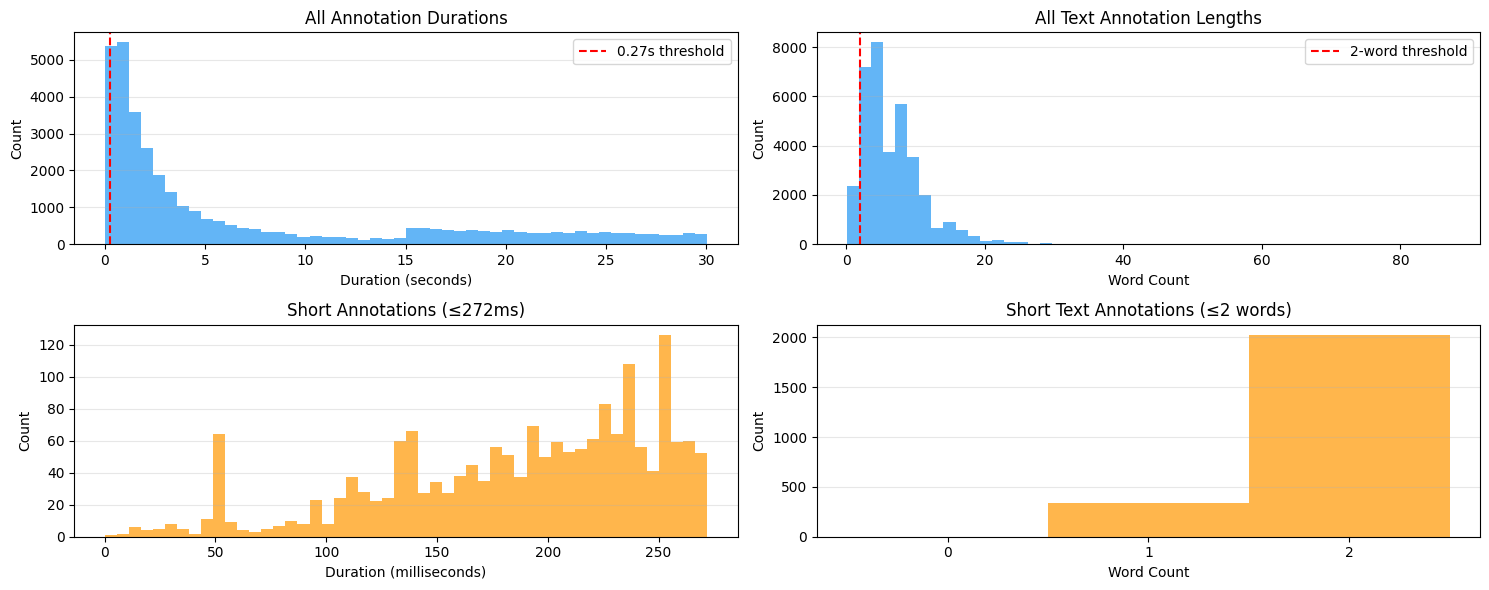

In [19]:
# Enhanced Histogram Visualization
plt.figure(figsize=(15, 6))

# Histogram 1: All Durations
plt.subplot(2, 2, 1)  # Row 1, Col 1
durations = annotations['duration']
plt.hist(durations, bins=50, color='#2196F3', alpha=0.7)
plt.title('All Annotation Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.axvline(x=compliance_metrics['enhanced']['min_duration'], 
            color='red', 
            linestyle='--', 
            label=f'{compliance_metrics['enhanced']['min_duration']:.2f}s threshold'
           )
plt.legend()

# Histogram 2: All Text Lengths
plt.subplot(2, 2, 2)  # Row 1, Col 2
text_lengths = annotations['text'].str.split().str.len()
plt.hist(text_lengths, bins=50, color='#2196F3', alpha=0.7, align='left')
plt.title('All Text Annotation Lengths')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.axvline(x=int(compliance_metrics['enhanced']['min_word_counts']), 
            color='red', 
            linestyle='--', 
            label=f'{int(compliance_metrics['enhanced']['min_word_counts'])}-word threshold'
           )
plt.legend()

# Histogram 3: Short Durations (<Q5)
plt.subplot(2, 2, 3)  # Row 2, Col 1
short_durations = annotations[annotations['duration'] < compliance_metrics['enhanced']['min_duration']]
durations_ms = short_durations['duration'] * 1000
plt.hist(durations_ms, bins=50, color='#FF9800', alpha=0.7)
plt.title(f'Short Annotations (≤{compliance_metrics['enhanced']['min_duration'] * 1000:.0f}ms)')
plt.xlabel('Duration (milliseconds)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

# Histogram 4: Short Texts (<Q5)
plt.subplot(2, 2, 4)  # Row 2, Col 2
short_texts = annotations[annotations['text'].str.split().str.len() < 3]
text_lengths = short_texts['text'].str.split().str.len()
plt.hist(text_lengths, bins=[0,1,2,3], color='#FF9800', alpha=0.7, align='left')
plt.title(f'Short Text Annotations (≤{int(compliance_metrics['enhanced']['min_word_counts'])} words)')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.xticks([0,1,2])
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

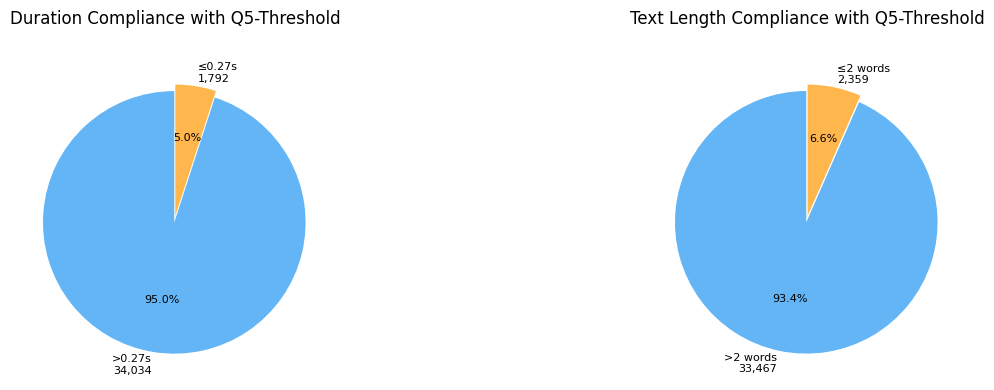

In [20]:
# Enhanced Pie-Chart Visualization
plt.figure(figsize=(15, 4))

# Pie Chart 1: Duration Compliance with Q5-Threshold
plt.subplot(1, 2, 1)  # Row 1, Col 1
duration_compliance = (annotations['duration']) <= compliance_metrics['enhanced']['min_duration']
duration_counts = duration_compliance.value_counts()
plt.pie(duration_counts, 
        labels=[f'>{compliance_metrics['enhanced']['min_duration']:.2f}s\n{duration_counts[False]:,}', 
                f'≤{compliance_metrics['enhanced']['min_duration']:.2f}s\n{duration_counts[True]:,}'],
        autopct='%1.1f%%',
        colors=['#2196F3', '#FF9800'],
        startangle=90,
        wedgeprops={'alpha': 0.7, 'linewidth': 1},
        explode=(0.05, 0),
        textprops={'fontsize': 8}
       )
plt.title('Duration Compliance with Q5-Threshold', pad=20)

# Pie Chart 2: Text Length Compliance with Q5-Threshold
plt.subplot(1, 2, 2)  # Row 1, Col 2
text_compliance = annotations['text'].str.split().str.len() <= compliance_metrics['enhanced']['min_word_counts']
text_counts = text_compliance.value_counts()
plt.pie(text_counts,
        labels=[f'>{int(compliance_metrics['enhanced']['min_word_counts'])} words\n{text_counts[False]:,}', 
                f'≤{int(compliance_metrics['enhanced']['min_word_counts'])} words\n{text_counts[True]:,}'],
        autopct='%1.1f%%',
        colors=['#2196F3', '#FF9800'],
        startangle=90,
        wedgeprops={'alpha': 0.7, 'linewidth': 1},
        explode=(0.05, 0),
        textprops={'fontsize': 8}
       )
plt.title('Text Length Compliance with Q5-Threshold', pad=20)

plt.tight_layout()
plt.show()

## Task 2: Annotation Quality:

### Task 2 (a): Temporal Precision

In [21]:
# Temporal Precision Analysis
print("\n" + "="*80)
print("Temporal Annotation Precision Analysis")
print("="*80)

# Calculate IoU between all annotation pairs per file
temporal_stats = annotations.groupby('filename').apply(annotations_agreement).dropna()

# Filter files with at least 2 annotators
valid_files = temporal_stats[(temporal_stats['n_annotators'] >= 2)]
mean_iou = valid_files['temporal_iou'].mean()
median_iou = valid_files['temporal_iou'].median()

print(f"{'Mean Temporal IoU: ':<25}{mean_iou:5.2f}")
print(f"{'Median Temporal IoU: ':<25}{median_iou:5.2f}")
print(f"{'% of files with IoU>0.5: ':<25}{(valid_files['temporal_iou'] > 0.5).mean():5.2%}")


Temporal Annotation Precision Analysis
Mean Temporal IoU:        0.42
Median Temporal IoU:      0.21
% of files with IoU>0.5: 34.75%


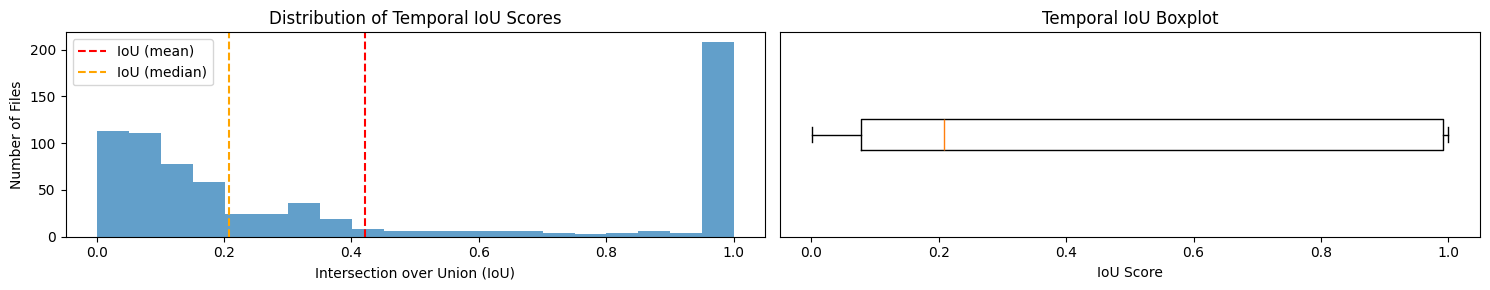

In [22]:
# Visualization
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.hist(valid_files['temporal_iou'], bins=20, alpha=0.7)
plt.axvline(x=mean_iou, color='red', linestyle='--', label='IoU (mean)')
plt.axvline(x=median_iou, color='orange', linestyle='--', label='IoU (median)')
plt.title('Distribution of Temporal IoU Scores')
plt.xlabel('Intersection over Union (IoU)')
plt.ylabel('Number of Files')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(valid_files['temporal_iou'], vert=False)
plt.title('Temporal IoU Boxplot')
plt.xlabel('IoU Score')
plt.yticks([])
plt.tight_layout()
plt.show()

### Task 2 (b): Text Similarity

In [23]:
# Textual Similarity Analysis
print("\n" + "="*80)
print("Textual Annotation Similarity Analysis")
print("="*80)

mean_text_sim = valid_files['textual_sim'].mean()
median_text_sim = valid_files['textual_sim'].median()

print(f"{'Mean Textual Similarity: ':<35}{mean_text_sim:5.2f}")
print(f"{'Median Textual Similarity: ':<35}{median_text_sim:5.2f}")
print(f"{'% of files with Similarity>0.5: ':<35}{(valid_files['textual_sim'] > 0.5).mean():5.2%}")


Textual Annotation Similarity Analysis
Mean Textual Similarity:            0.44
Median Textual Similarity:          0.42
% of files with Similarity>0.5:    37.35%


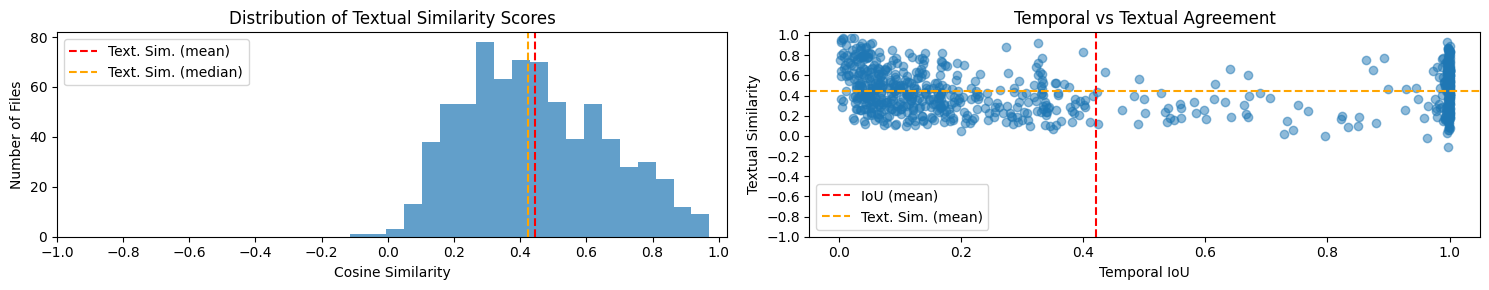

In [24]:
# Visualization
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.hist(valid_files['textual_sim'], bins=20, alpha=0.7)
plt.axvline(x=mean_text_sim, color='red', linestyle='--', label='Text. Sim. (mean)')
plt.axvline(x=median_text_sim, color='orange', linestyle='--', label='Text. Sim. (median)')
plt.title('Distribution of Textual Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.xticks(np.arange(-1.0, 1.1, 0.2))
plt.ylabel('Number of Files')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(valid_files['temporal_iou'], valid_files['textual_sim'], alpha=0.5)
plt.axvline(x=mean_iou, color='red', linestyle='--', label='IoU (mean)')
plt.axhline(y=mean_text_sim, color='orange', linestyle='--', label='Text. Sim. (mean)')
plt.title('Temporal vs Textual Agreement')
plt.xlabel('Temporal IoU')
plt.ylabel('Textual Similarity')
plt.yticks(np.arange(-1.0, 1.1, 0.2))
plt.legend()
plt.tight_layout()
plt.show()

### Task 2 (c): Annotation Quantity

In [25]:
# Annotation Quantity Analysis
print("\n" + "="*80)
print("Annotation Quantity Analysis")
print("="*80)

# Annotations per file
annotations_per_file = annotations.groupby('filename').size()
mean_annots = annotations_per_file.mean()
median_annots = annotations_per_file.median()

# Distinct sound events per file
distinct_events = annotations.groupby('filename')['text'].nunique()
mean_events = distinct_events.mean()
median_events = distinct_events.median()

print(f"{'Mean annotations per file: ':<35}{mean_annots:.1f}")
print(f"{'Median annotations per file: ':<35}{median_annots:.1f}")
print(f"{'Mean distinct events per file: ':<35}{mean_events:.1f}")
print(f"{'Median distinct events per file: ':<35}{median_events:.1f}")


Annotation Quantity Analysis
Mean annotations per file:         4.0
Median annotations per file:       2.0
Mean distinct events per file:     2.7
Median distinct events per file:   2.0


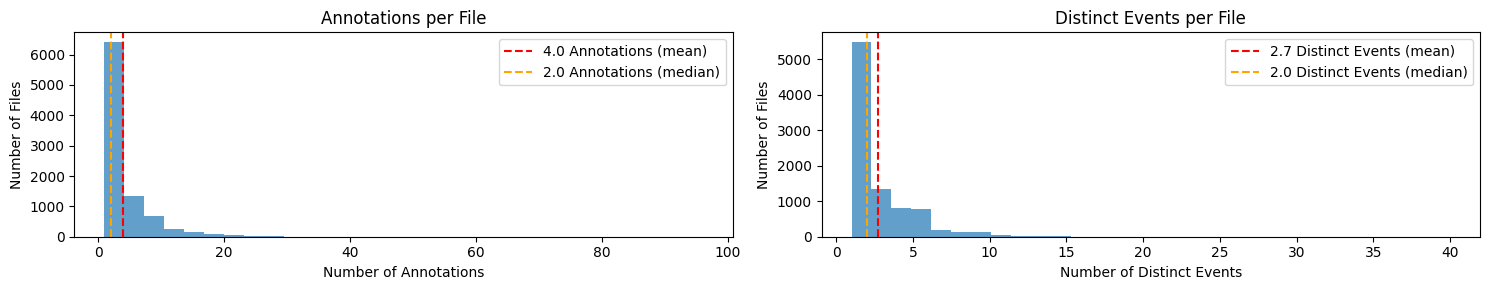

In [26]:
# Visualization
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.hist(annotations_per_file, bins=30, alpha=0.7)
plt.axvline(x=mean_annots, color='red', linestyle='--', label=f'{mean_annots:.1f} Annotations (mean)')
plt.axvline(x=median_annots, color='orange', linestyle='--', label=f'{median_annots:.1f} Annotations (median)')
plt.title('Annotations per File')
plt.xlabel('Number of Annotations')
plt.ylabel('Number of Files')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(distinct_events, bins=30, alpha=0.7)
plt.axvline(x=mean_events, color='red', linestyle='--', label=f'{mean_events:.1f} Distinct Events (mean)')
plt.axvline(x=median_events, color='orange', linestyle='--', label=f'{median_events:.1f} Distinct Events (median)')
plt.title('Distinct Events per File')
plt.xlabel('Number of Distinct Events')
plt.ylabel('Number of Files')
plt.legend()
plt.tight_layout()
plt.show()

### Task 2 (d): Annotator Quality

In [27]:
# Annotator Quality Analysis
print("="*80)
print("Annotator Quality Analysis")
print("="*80)

# Calculate annotator-level metrics
annotator_stats = annotations.groupby('annotator').agg({
    'text': [
        ('count', 'size'),
        ('avg_words', lambda x: x.str.split().str.len().mean()),
        ('unique_terms', lambda x: len(set(' '.join(x).lower().split())))
    ],
    'onset': [('avg_duration', lambda x: (annotations.loc[x.index, 'offset'] - x).mean())]
})

# Flatten multi-index columns
annotator_stats.columns = ['_'.join(col) for col in annotator_stats.columns.values]

# Detect outliers using IQR
def flag_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return (series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))

annotator_stats['outlier_count'] = flag_outliers(annotator_stats['text_count'])
annotator_stats['outlier_words'] = flag_outliers(annotator_stats['text_avg_words'])
annotator_stats['outlier_duration'] = flag_outliers(annotator_stats['onset_avg_duration'])

# Calculate total and flagged annotators
total_annotators = len(annotator_stats)
total_flagged = annotator_stats[['outlier_count', 'outlier_words', 'outlier_duration']].any(axis=1).sum()
good_annotators = total_annotators - total_flagged


# Print summary
print(f"{'Total annotators':<35}:{total_annotators:>3}")
print(f"{'Total outlier annotators':<35}:{total_flagged:>3}\t({total_flagged/total_annotators:5.1%})")
print(f"{'Remaining good annotators':<35}:{good_annotators:>3}\t({good_annotators/total_annotators:5.1%})")

print("\nBreakdown of flagged annotators:")
print("-"*80)
print(f"{'- Low count':<35}:{annotator_stats['outlier_count'].sum():>2}")
print(f"{'- Short texts':<35}:{annotator_stats['outlier_words'].sum():>2}")
print(f"{'- Unusual durations':<35}:{annotator_stats['outlier_duration'].sum():>2}")

Annotator Quality Analysis
Total annotators                   :330
Total outlier annotators           : 31	( 9.4%)
Remaining good annotators          :299	(90.6%)

Breakdown of flagged annotators:
--------------------------------------------------------------------------------
- Low count                        : 5
- Short texts                      :19
- Unusual durations                :11


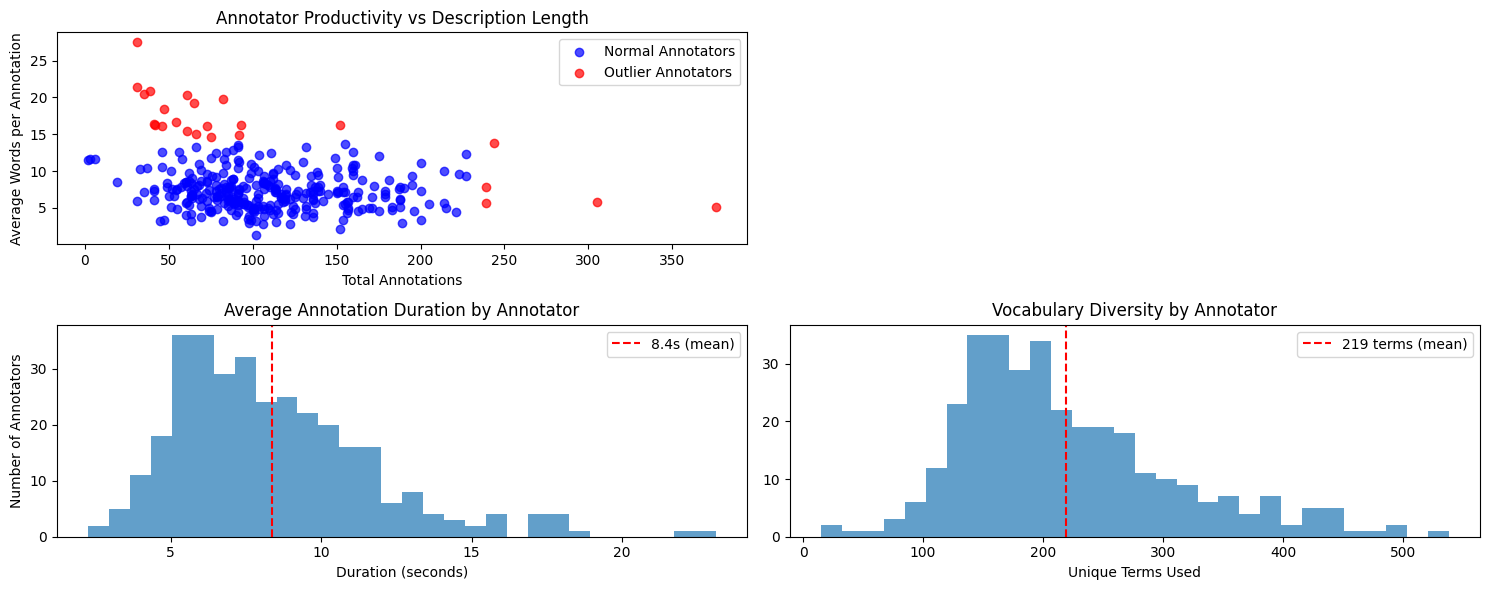

In [28]:
# Visualization
plt.figure(figsize=(15, 6))

# Create separate masks for different outlier types
outlier_mask = (annotator_stats['outlier_count'] | annotator_stats['outlier_words'])
normal_mask = ~outlier_mask

plt.subplot(2, 2, 1)
scatter1 = plt.scatter(annotator_stats.loc[normal_mask, 'text_count'], 
                      annotator_stats.loc[normal_mask, 'text_avg_words'], 
                      c='blue', alpha=0.7, label='Normal Annotators')

scatter2 = plt.scatter(annotator_stats.loc[outlier_mask, 'text_count'], 
                      annotator_stats.loc[outlier_mask, 'text_avg_words'], 
                      c='red', alpha=0.7, label='Outlier Annotators')

plt.title('Annotator Productivity vs Description Length')
plt.xlabel('Total Annotations')
plt.ylabel('Average Words per Annotation')
plt.legend(handles=[scatter1, scatter2], loc='upper right')


plt.subplot(2, 2, 3)
plt.hist(annotator_stats['onset_avg_duration'], bins=30, alpha=0.7)
plt.title('Average Annotation Duration by Annotator')
plt.axvline(x=annotator_stats['onset_avg_duration'].mean(), color='red', linestyle='--', label=f'{annotator_stats['onset_avg_duration'].mean():.1f}s (mean)')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of Annotators')
plt.legend()

plt.subplot(2, 2, 4)
plt.hist(annotator_stats['text_unique_terms'], bins=30, alpha=0.7)
plt.title('Vocabulary Diversity by Annotator')
plt.axvline(x=annotator_stats['text_unique_terms'].mean(), color='red', linestyle='--', label=f'{annotator_stats['text_unique_terms'].mean():.0f} terms (mean)')
plt.xlabel('Unique Terms Used')
plt.legend()

plt.tight_layout()
plt.show()

### (e) Quality Filtering

In [29]:
# Proposed quality filter
def quality_filter(df, 
                  min_words=compliance_metrics['enhanced']['min_word_counts'], 
                  min_duration=compliance_metrics['enhanced']['min_duration'],
                  exclude_outliers=True):
    """Filter annotations based on quality criteria"""
    
    # Basic content requirements
    mask = (
        (df['text'].str.split().str.len() >= min_words) & 
        (df['duration'] >= min_duration)
    )

    if exclude_outliers:
        # Annotator quality requirements
        good_annotators = annotator_stats[~annotator_stats.filter(like='outlier').any(axis=1)].index
        mask &= df['annotator'].isin(good_annotators)
    
    return df[mask]

# Apply quality filter on annotations
filtered_annotations = quality_filter(annotations)

# Calculate impact on annotations
original_annotations = len(annotations)
remaining_annotations = len(filtered_annotations)
removed_annotations = len(annotations) - len(filtered_annotations)
removed_pct_annotations = removed_annotations / len(annotations)

# Calculate impact on annotators
original_annotators = annotations['annotator'].nunique()
remaining_annotators = filtered_annotations['annotator'].nunique()
removed_annotators = original_annotators - remaining_annotators
removed_pct_annotators = removed_annotators / original_annotators

# Print Quality Filter Criteria
print("="*80)
print("Annotation Quality Filter Analysis")
print("="*80)
print("\nFilter Criteria:")
print("-"*80)
print(f"{'Minimum words per annotation':<30}:{compliance_metrics['enhanced']['min_word_counts']:>10.0f}")
print(f"{'Minimum duration (seconds)':<30}:{compliance_metrics['enhanced']['min_duration']:>10.2f}")
print(f"{'Exclude outlier annotators':<30}:{'Yes':>10}")

print("\nAnnotation Impact:")
print("-"*80)
print(f"{'Original annotations':<30}:{original_annotations:>10,}")
print(f"{'Remaining annotations':<30}:{remaining_annotations:>10,}")
print(f"{'Removed annotations':<30}:{removed_annotations:>10,}")
print(f"{'Percentage removed':<30}:{removed_pct_annotations:>10.1%}")

print("\nAnnotator Impact:")
print("-"*80)
print(f"{'Original annotators':<30}:{original_annotators:>10,}")
print(f"{'Remaining annotators':<30}:{remaining_annotators:>10,}")
print(f"{'Removed annotators':<30}:{removed_annotators:>10,}")
print(f"{'Percentage removed':<30}:{removed_pct_annotators:>10.1%}")

Annotation Quality Filter Analysis

Filter Criteria:
--------------------------------------------------------------------------------
Minimum words per annotation  :         2
Minimum duration (seconds)    :      0.27
Exclude outlier annotators    :       Yes

Annotation Impact:
--------------------------------------------------------------------------------
Original annotations          :    35,826
Remaining annotations         :    31,147
Removed annotations           :     4,679
Percentage removed            :     13.1%

Annotator Impact:
--------------------------------------------------------------------------------
Original annotators           :       330
Remaining annotators          :       299
Removed annotators            :        31
Percentage removed            :      9.4%
